# Retail Price Optimization

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import zipfile

### 2. Load Data

In [2]:
# Extract the ZIP file
zip_file_path = 'Retail Price Optimization.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('retail_price_data')

# Load the dataset
csv_file_path = 'retail_price_data/retail_price.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(data.head())

# Data Inspection
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Overview:
  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  \
0              

### 3. PreProcess Data

In [3]:
# Feature Engineering
# Convert 'month_year' to datetime format
data['month_year'] = pd.to_datetime(data['month_year'], format='%m-%d-%Y')

# Extract month and day of the week from 'month_year'
data['month'] = data['month_year'].dt.month
data['day_of_week'] = data['month_year'].dt.dayofweek

# Add seasonality feature (e.g., holiday season)
data['is_holiday_season'] = data['month'].apply(lambda x: 1 if x in [11, 12] else 0)

# Add price elasticity feature
data['Price_Elasticity'] = data['qty'] / data['unit_price']

# Normalize numerical features
scaler = MinMaxScaler()
numeric_features = ['unit_price', 'freight_price', 'comp_1', 'comp_2', 'comp_3', 'Price_Elasticity']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Add interaction features
interaction_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_data = interaction_features.fit_transform(data[numeric_features])
interaction_df = pd.DataFrame(interaction_data, columns=interaction_features.get_feature_names_out(numeric_features))
data = pd.concat([data, interaction_df], axis=1)

In [4]:
# One-Hot Encoding for Categorical Features
categorical_features = ['product_category_name', 'month', 'day_of_week']
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(data[categorical_features]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))
data = pd.concat([data, encoded_df], axis=1)

# Prepare features and target
features = list(interaction_df.columns) + list(encoded_df.columns)
X = data[features]
y = data['qty']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Model Selection and Hyperparameter Tuning

In [5]:
# Remove duplicate columns from X_train and X_test
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Model Selection and Hyperparameter Tuning
models = {
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }),
    'XGBoost': (XGBRegressor(objective='reg:squarederror', random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    })
}

### 5. RandomizedSearch and Evaluae Best Models

In [6]:
# Perform RandomizedSearchCV for each model
best_models = {}
for model_name, (model, param_grid) in models.items():
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid, 
        n_iter=50, cv=3, random_state=42, n_jobs=-1, 
        scoring='neg_mean_squared_error'
    )
    
    random_search.fit(X_train, y_train)
    best_models[model_name] = random_search.best_estimator_
    print(f"Best {model_name} Parameters: {random_search.best_params_}")

# Evaluate the best models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.2f}")

Best RandomForest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Best XGBoost Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best GradientBoosting Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
RandomForest - MSE: 5.97, MAE: 0.84, MAPE: 0.04, R²: 0.98
XGBoost - MSE: 1.76, MAE: 0.65, MAPE: 0.05, R²: 0.99
GradientBoosting - MSE: 4.57, MAE: 0.69, MAPE: 0.05, R²: 0.98


### 6. Feature Importance

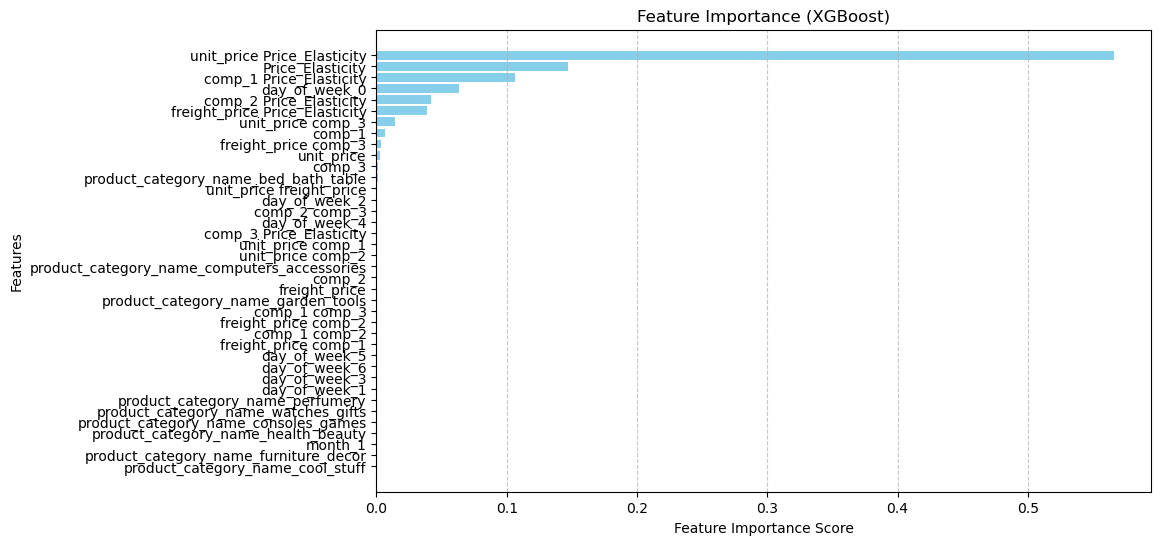

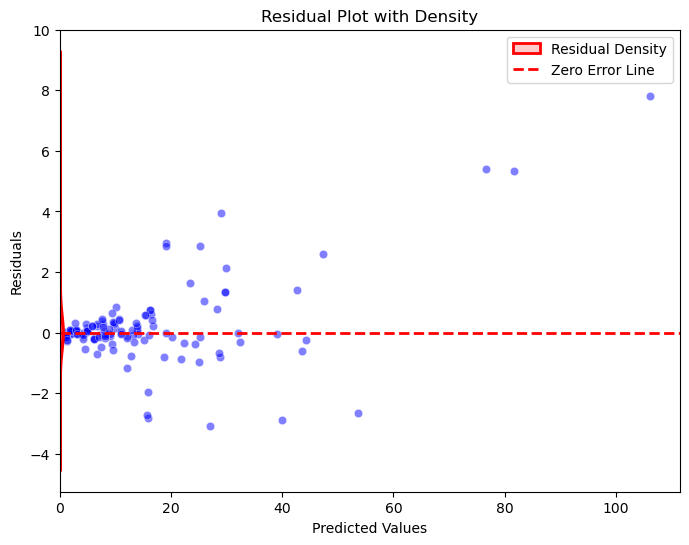

In [7]:
# Feature Importance for the best model (XGBoost in this case)
best_model = best_models['XGBoost']
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(best_model.feature_importances_)[::-1]  # Sort in descending order
sorted_features = X_train.columns[sorted_idx]

plt.barh(sorted_features, best_model.feature_importances_[sorted_idx], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (XGBoost)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()  # Most important features on top
plt.show()

# Error Analysis: Residual Plot
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='blue')
sns.kdeplot(y=residuals, color='red', lw=2, label="Residual Density", fill=True, alpha=0.2)
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Error Line")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot with Density")
plt.legend()
plt.show()

### 7. Price Optimization

In [8]:
# Define price range for optimization
price_range = np.linspace(X_train['unit_price'].min(), X_train['unit_price'].max(), 50)

# Create a DataFrame with all features set to their training means
simulated_data = pd.DataFrame(np.tile(X_train.mean().values, (len(price_range), 1)), columns=X_train.columns)

# Replace 'unit_price' column with varying price points
simulated_data['unit_price'] = price_range

# Predict demand for each price point
simulated_demand = best_model.predict(simulated_data)

# Ensure demand is non-negative
simulated_demand = np.maximum(simulated_demand, 0)

# Calculate revenue: Revenue = Price × Demand
revenue = price_range * simulated_demand

# Determine the optimal price that maximizes revenue
optimal_price = price_range[np.argmax(revenue)]

print(f"Optimal Price: ${optimal_price:.2f}")

Optimal Price: $1.00


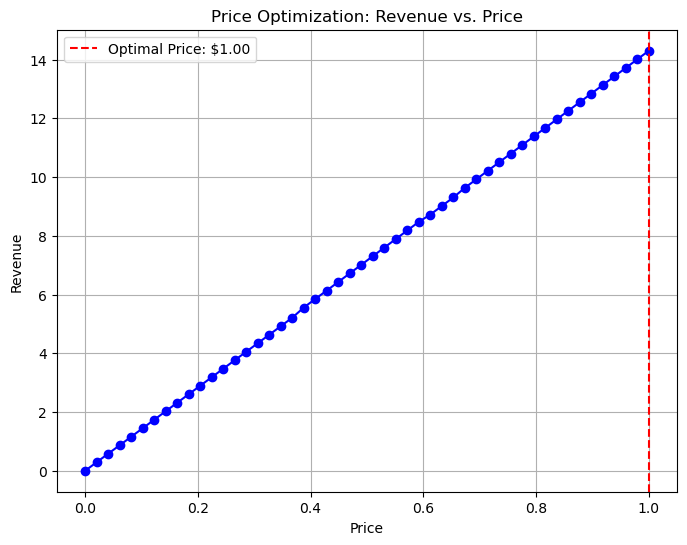

In [9]:
# Plot revenue vs. price

plt.figure(figsize=(8, 6))
plt.plot(price_range, revenue, marker='o', linestyle='-', color='blue')
plt.axvline(optimal_price, color='red', linestyle='--', label=f"Optimal Price: ${optimal_price:.2f}")
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.title("Price Optimization: Revenue vs. Price")
plt.legend()
plt.grid()
plt.show()